In [1]:
import tensorflow as tf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import copy
import os
import re
import random

# import jieba
# import jieba.analyse


## 文字前處理

In [2]:
before_dir_name = './ptt/'
after_dir_name = './after/'

before_file_names = [f for f in os.listdir(before_dir_name) if not f.startswith('.')]
print(before_file_names)

['國民黨.txt', '民進黨.txt', '中共.txt', '陳水扁.txt', '蔡英文.txt', '智障.txt', '苗博雅.txt', '吳怡農.txt', '民眾黨.txt', '習近平.txt', '柯文哲.txt', '賴清德.txt', '二戰.txt', '蘇貞昌.txt', '垃圾.txt', '高虹安.txt', '炒房.txt', '時代.txt', '馬英九.txt', '低能.txt', '蔣萬安.txt']


In [3]:
for file_name in before_file_names:
    before_file_path = os.path.join(before_dir_name, file_name)
    after_file_path = os.path.join(after_dir_name, file_name)
    new_lines = []
    # 打開文字檔
    with open(before_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        # 類似網址文字去除
        line = re.sub(r'http\S+', '', line)
        
        # 將純數字句子去除
        if re.match(r'\d+$', line):
            line = re.sub(r'\b\d+\b', '', line)
        # 將純英文句子去除
        if re.match(r'^[a-zA-Z]+$', line):
            line = re.sub(r'^[a-zA-Z]+$', '', line)
        # 將太短句子跳過
        if len(line) < 4:
            continue
        # 將過長句子刪減
        if len(line) > 12:
            line = line[:12]
        if line.strip():
            new_lines.append(line)
    with open(after_file_path, 'w') as f:
        f.writelines(new_lines)
        

## CKIP 分詞 (ckiptagger)

In [4]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

In [5]:
# data_utils.download_data_gdown("./")

In [6]:
ws = WS("./data")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


Metal device set to: Apple M1 Pro


2022-12-17 20:30:16.606249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 20:30:16.606343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-17 20:30:16.619009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-17 20:30:16.675553: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-17 20:30:16.683017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 20:30:16.947924: I tensorflow/core/grappler/optimizers/custom_graph

## 取得詞彙黑白名單，建立冒犯詞彙詞典

In [7]:
Non_offensive_dict = {}

In [8]:
with open('whitelist.txt', 'r') as f:
    lines = f.read().replace('\n', ' ').split()
    
weight = 1
for line in lines:
    # 取得權重
    if line.isdigit() and len(line) == 1:
        weight = int(line)
    else:
        if line not in Non_offensive_dict:
            Non_offensive_dict[line] = 1
        Non_offensive_dict[line] = weight

In [9]:
Non_offensive_dict

{'我': 1,
 '我是': 1,
 '自肥': 1,
 '自': 1,
 '好': 1,
 '好好': 1,
 '好的': 1,
 'QQ': 1,
 'qq': 1,
 'XD': 1,
 'Xd': 1,
 'xD': 1,
 'xd': 1,
 'OK': 1,
 '你': 1,
 '你好': 1,
 '你的': 1,
 '您': 1,
 '您的': 1,
 '您好': 1,
 '是': 1,
 '否': 1,
 '不': 1,
 '不是': 1,
 '不要': 1,
 '不行': 1,
 '不可': 1,
 '不可以': 1,
 '可': 1,
 '可以': 1,
 '問': 1,
 '餒': 1,
 '幹嘛': 1,
 '幹麼': 1,
 '沒錯': 1,
 '沒事': 1,
 '不知道': 1,
 '高': 1,
 '對': 1,
 '我的': 1,
 '有': 1,
 '無': 1,
 '正解': 1,
 '喜歡': 1,
 '討厭': 1,
 '乖': 1,
 '暖': 1,
 '笑': 1,
 '贊同': 2,
 '讚': 2,
 '請': 2,
 '謝謝': 2,
 '參考': 2,
 '對不起': 2,
 '很棒': 2,
 '同意': 2,
 '拒絕': 2,
 '太好': 2,
 '禮貌': 2,
 '先生': 2,
 '女士': 2,
 '小姐': 2,
 '好人': 2}

In [10]:
offensive_dict = {}

In [11]:
with open('blacklist.txt', 'r') as f:
    lines = f.read().replace('\n', ' ').split()
    
weight = 1
for line in lines:
    # 取得權重
    if line.isdigit() and len(line) == 1:
        weight = int(line)
    else:
        if line not in offensive_dict:
            offensive_dict[line] = 1
        offensive_dict[line] = weight

In [12]:
offensive_dict

{'廢物': 3,
 '廢物仔': 3,
 '廢渣': 3,
 '垃圾': 3,
 '垃圾仔': 3,
 '怪胎': 3,
 '破腦': 3,
 '腦殘': 3,
 '腦殘仔': 3,
 '腦破': 3,
 '腦破仔': 3,
 '腦癱': 3,
 '精障': 3,
 '精障仔': 3,
 '智障': 3,
 '智障仔': 3,
 '製帳': 3,
 '吱障': 3,
 '吱吱': 3,
 '糞青': 3,
 '啟包': 3,
 '啟智': 3,
 '啟智兒': 3,
 '啟智仔': 3,
 '低能': 3,
 '低能兒': 3,
 '低能仔': 3,
 '滴能兒': 3,
 '弱智': 3,
 '弱智仔': 3,
 '番仔': 3,
 '死港仔': 3,
 '雜種': 3,
 '黑鬼': 3,
 '黑奴': 3,
 '尼哥': 3,
 '倭寇': 3,
 '鬼子': 3,
 '韓狗': 3,
 '港狗': 3,
 '日狗': 3,
 '台狗': 3,
 '棒子': 3,
 '426': 3,
 '26': 3,
 '死阿陸': 3,
 '阿陸': 3,
 '阿陸仔': 3,
 '中國豬': 3,
 '支那豬': 3,
 '白皮豬': 3,
 '台巴子': 3,
 '大陸妹': 3,
 '大陸佬': 3,
 '綠畜': 3,
 '綠蛆': 3,
 '綠吱': 3,
 '藍蛆': 3,
 '藍畜': 3,
 '支畜': 3,
 '賤畜': 3,
 '支那': 3,
 '支那人': 3,
 '肥子': 3,
 '肥男': 3,
 '肥佬': 3,
 '肥婆': 3,
 '肥豬': 3,
 '肥甲': 3,
 '胖男': 3,
 '胖子': 3,
 '恐龍妹': 3,
 '老妖婆': 3,
 '妖婆': 3,
 '老處女': 3,
 '老太婆': 3,
 '剩女': 3,
 '母豬': 3,
 '噁男': 3,
 '噁女': 3,
 '臭甲': 3,
 '死甲甲': 3,
 '基佬': 3,
 '婊子': 3,
 '臭婊': 3,
 '臭妓': 3,
 '蕩婦': 3,
 '賣淫': 3,
 '破麻': 3,
 '男妓': 3,
 '妓女': 3,
 '娼妓': 3,
 '婊': 3,
 '妓': 3,
 '娘娘腔': 3,
 '娘炮': 3,
 '男人婆': 3,
 '

In [13]:
new_dict = dict(Non_offensive_dict)
new_dict.update(offensive_dict)

In [14]:
new_dict

{'我': 1,
 '我是': 1,
 '自肥': 1,
 '自': 1,
 '好': 1,
 '好好': 1,
 '好的': 1,
 'QQ': 1,
 'qq': 1,
 'XD': 1,
 'Xd': 1,
 'xD': 1,
 'xd': 1,
 'OK': 1,
 '你': 1,
 '你好': 1,
 '你的': 1,
 '您': 1,
 '您的': 1,
 '您好': 1,
 '是': 1,
 '否': 1,
 '不': 1,
 '不是': 1,
 '不要': 1,
 '不行': 1,
 '不可': 1,
 '不可以': 1,
 '可': 1,
 '可以': 1,
 '問': 1,
 '餒': 1,
 '幹嘛': 1,
 '幹麼': 1,
 '沒錯': 1,
 '沒事': 1,
 '不知道': 1,
 '高': 1,
 '對': 1,
 '我的': 1,
 '有': 1,
 '無': 1,
 '正解': 1,
 '喜歡': 1,
 '討厭': 1,
 '乖': 1,
 '暖': 1,
 '笑': 1,
 '贊同': 2,
 '讚': 2,
 '請': 2,
 '謝謝': 2,
 '參考': 2,
 '對不起': 2,
 '很棒': 2,
 '同意': 2,
 '拒絕': 2,
 '太好': 2,
 '禮貌': 2,
 '先生': 2,
 '女士': 2,
 '小姐': 2,
 '好人': 2,
 '廢物': 3,
 '廢物仔': 3,
 '廢渣': 3,
 '垃圾': 3,
 '垃圾仔': 3,
 '怪胎': 3,
 '破腦': 3,
 '腦殘': 3,
 '腦殘仔': 3,
 '腦破': 3,
 '腦破仔': 3,
 '腦癱': 3,
 '精障': 3,
 '精障仔': 3,
 '智障': 3,
 '智障仔': 3,
 '製帳': 3,
 '吱障': 3,
 '吱吱': 3,
 '糞青': 3,
 '啟包': 3,
 '啟智': 3,
 '啟智兒': 3,
 '啟智仔': 3,
 '低能': 3,
 '低能兒': 3,
 '低能仔': 3,
 '滴能兒': 3,
 '弱智': 3,
 '弱智仔': 3,
 '番仔': 3,
 '死港仔': 3,
 '雜種': 3,
 '黑鬼': 3,
 '黑奴': 3,
 '尼哥': 3,
 '倭寇': 3,
 '鬼子

In [15]:
dict_for_CKIP = construct_dictionary(new_dict)
dict_for_CKIP

[(1,
  {'我': 1.0,
   '自': 1.0,
   '好': 1.0,
   '你': 1.0,
   '您': 1.0,
   '是': 1.0,
   '否': 1.0,
   '不': 1.0,
   '可': 1.0,
   '問': 1.0,
   '餒': 1.0,
   '高': 1.0,
   '對': 1.0,
   '有': 1.0,
   '無': 1.0,
   '乖': 1.0,
   '暖': 1.0,
   '笑': 1.0,
   '讚': 2.0,
   '請': 2.0,
   '婊': 3.0,
   '妓': 3.0,
   '幹': 2.0,
   '淦': 2.0,
   '贛': 2.0,
   '癡': 2.0,
   '痴': 2.0,
   '蠢': 2.0,
   '笨': 2.0,
   '憨': 2.0,
   '靠': 2.0,
   '醜': 2.0,
   '糙': 2.0,
   '操': 2.0,
   '肏': 2.0,
   '尛': 2.0,
   '洨': 2.0,
   '糞': 2.0,
   '屎': 2.0,
   '尿': 2.0,
   '屁': 2.0,
   '屌': 2.0,
   '屄': 2.0,
   '尻': 2.0,
   '肛': 2.0,
   '逼': 2.0,
   '賤': 2.0,
   '狗': 2.0,
   '豬': 2.0,
   '肥': 2.0,
   '胖': 2.0,
   '畜': 2.0,
   '孬': 2.0,
   '渣': 2.0,
   '瘸': 2.0,
   '呆': 1.0,
   '蟲': 1.0,
   '騙': 1.0,
   '蛙': 1.0,
   '盲': 1.0,
   '怪': 1.0,
   '噁': 1.0,
   '爛': 1.0,
   '滾': 1.0,
   '秋': 1.0,
   '奴': 1.0,
   '甲': 1.0,
   '死': 1.0,
   '殺': 1.0,
   '廢': 1.0,
   '性': 1.0,
   '淫': 1.0,
   '蕩': 1.0,
   '嫩': 1.0,
   '弱': 1.0,
   '破': 1.0,
   '屑':

In [16]:
sentence_list = []

after_dir_names = [f for f in os.listdir(after_dir_name) if not f.startswith('.')]
print(after_dir_names)

for file_name in after_dir_names:
    after_file_path = os.path.join(after_dir_name, file_name)
    
    with open(after_file_path, 'r') as f:
        lines = f.read().replace('\n', ' ').split()
    
    for line in lines:
        
        # 跳過空行
        if line.strip():
            sentence_list.append(line)
            
print(len(sentence_list))


['國民黨.txt', '民進黨.txt', '中共.txt', '陳水扁.txt', '蔡英文.txt', '智障.txt', '苗博雅.txt', '吳怡農.txt', '民眾黨.txt', '習近平.txt', '柯文哲.txt', '賴清德.txt', '二戰.txt', '蘇貞昌.txt', '垃圾.txt', '高虹安.txt', '炒房.txt', '時代.txt', '馬英九.txt', '低能.txt', '蔣萬安.txt']
105046


## 算出平均長度

In [17]:
total_length = sum(len(s) for s in sentence_list)
average_length = total_length / len(sentence_list)

In [18]:
print(total_length, average_length)

3360663 31.99229861203663


## 隨機取一部分（全做斷詞太花時間）

In [19]:
selected_sentence_list = random.sample(sentence_list, 5000)

## 算出隨機取樣的平均長度

In [20]:
selected_total_length = sum(len(s) for s in selected_sentence_list)
selected_average_length = selected_total_length / len(selected_sentence_list)

In [21]:
print(selected_total_length, selected_average_length)

161334 32.2668


## 開始斷詞

In [22]:
word_sentence_list = ws(
    selected_sentence_list,
    # sentence_segmentation = True, # To consider delimiters
    # segment_delimiter_set = {",", "。", ":", "?", "!", ";"}), # This is the defualt set of delimiters
    recommend_dictionary = dict_for_CKIP, # words in this dictionary are encouraged
    # coerce_dictionary = dictionary2, # words in this dictionary are forced
)

2022-12-17 20:30:17.267542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [23]:
df = pd.DataFrame(selected_sentence_list, columns=['sentences'])
df

,sentences
0,便宜的看姓就知道是滯台支那人呵呵
1,選前就應該抓去關了已經很明顯老柯輸不起
2,我不敢中國覺青
3,33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看...
4,分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也...
...,...
4995,還在煩好了沒柯已回歸專業嗎？解釋了什麼？屁話真的多真的謙卑謙卑再謙卑民進黨果然就是綠色共產黨...
4996,噁心幹你娘2024徐國勇先滾好嗎什麼重大政策？中介法？輸敗選者太多角逐院長
4997,有什麼好不適
4998,不意外我還以為是林聰明，還好樓這就博眼球的小丑，生意不哭啊


In [24]:
df['WS'] = np.array(word_sentence_list)
df 

/var/folders/rd/yxk_41h92vz6r66k9g09_fjw0000gn/T/ipykernel_21898/2966498574.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df['WS'] = np.array(word_sentence_list)


,sentences,WS
0,便宜的看姓就知道是滯台支那人呵呵,"[便宜, 的, 看, 姓, 就, 知道, 是, 滯, 台, 支那人, 呵呵]"
1,選前就應該抓去關了已經很明顯老柯輸不起,"[選, 前, 就, 應該, 抓去, 關, 了, 已經, 很, 明顯, 老柯, 輸不起]"
2,我不敢中國覺青,"[我, 不, 敢, 中國, 覺, 青]"
3,33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看...,"[33, 人間幹, 又, 要, 借, 不, 到, 車, 了, 蔣萬安, 除了, 帥, 跟, ..."
4,分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也...,"[分佔, 一二, 中興橋, 不, 智障, ，, 但, 最, 狹窄, 最, 改善, 前, 的,..."
...,...,...
4995,還在煩好了沒柯已回歸專業嗎？解釋了什麼？屁話真的多真的謙卑謙卑再謙卑民進黨果然就是綠色共產黨...,"[還, 在, 煩好, 了, 沒, 柯, 已, 回歸, 專業, 嗎, ？, 解釋, 了, 什麼..."
4996,噁心幹你娘2024徐國勇先滾好嗎什麼重大政策？中介法？輸敗選者太多角逐院長,"[噁心, 幹你娘, 2024, 徐國勇, 先, 滾好, 嗎, 什麼, 重大, 政策, ？, ..."
4997,有什麼好不適,"[有, 什麼, 好, 不適]"
4998,不意外我還以為是林聰明，還好樓這就博眼球的小丑，生意不哭啊,"[不, 意外, 我, 還, 以為, 是, 林聰明, ，, 還好, 樓, 這, 就, 博眼球,..."


In [25]:
type(df['WS'][0][0])

str

In [26]:
df.to_csv("ws.csv", encoding='utf_8_sig')

In [27]:
df = pd.read_csv("ws.csv")
df = df[['sentences', 'WS']]

In [28]:
df

,sentences,WS
0,便宜的看姓就知道是滯台支那人呵呵,"['便宜', '的', '看', '姓', '就', '知道', '是', '滯', '台'..."
1,選前就應該抓去關了已經很明顯老柯輸不起,"['選', '前', '就', '應該', '抓去', '關', '了', '已經', '很..."
2,我不敢中國覺青,"['我', '不', '敢', '中國', '覺', '青']"
3,33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看...,"['33', '人間幹', '又', '要', '借', '不', '到', '車', '了..."
4,分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也...,"['分佔', '一二', '中興橋', '不', '智障', '，', '但', '最', ..."
...,...,...
4995,還在煩好了沒柯已回歸專業嗎？解釋了什麼？屁話真的多真的謙卑謙卑再謙卑民進黨果然就是綠色共產黨...,"['還', '在', '煩好', '了', '沒', '柯', '已', '回歸', '專業..."
4996,噁心幹你娘2024徐國勇先滾好嗎什麼重大政策？中介法？輸敗選者太多角逐院長,"['噁心', '幹你娘', '2024', '徐國勇', '先', '滾好', '嗎', '..."
4997,有什麼好不適,"['有', '什麼', '好', '不適']"
4998,不意外我還以為是林聰明，還好樓這就博眼球的小丑，生意不哭啊,"['不', '意外', '我', '還', '以為', '是', '林聰明', '，', '..."


In [29]:
word_segment = df['WS'].tolist()

## TF-IDF 關鍵字加權

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [31]:
# 讀取 stop-words.txt
with open('stopword.txt', encoding='utf-8') as f:
    stop_word = f.read().replace('\n', ' ').split()

# 整理 stop-word
sw = stop_word

In [32]:
text_cv = CountVectorizer(max_df=0.75, min_df=1, stop_words=sw)

td_matrix = text_cv.fit_transform(word_segment)

print (td_matrix.shape)

print (text_cv.vocabulary_.keys())

print (len(text_cv.vocabulary_.keys()))

print(text_cv.get_feature_names_out())

print('============全部字詞=============')
print(text_cv.get_feature_names())
print()
print('==========各文件字詞統計==============')
print(td_matrix.toarray())
print()


(5000, 12094)
dict_keys(['便宜', '支那人', '抓去', '老柯', '輸不起', '中國', '33', '人間幹', '蔣萬安', '支票', '小時', '免費', '反正', '萬安', '好看', '草包', '低能', 'ubike', '分佔', '一二', '中興橋', '智障', '狹窄', '改善', '重陽橋', '福和橋', '真的', '低能兒', '設計', '白痴', '關渡橋', '分流', '改建', '機車道', '鄭弘儀', '走回', '節目', '習下', '李上', '山西', '布政司', '五千兩', '昨天', '館長', '直播', '提到', '兒山西', '老派', '反叛自爆', '漏聽', '柯有自爆', 'xdd', '笑死', '理工人', '爛綠', '爆惹', '可憐', '幾萬', '承諾', '收回', '臉拱', '將軍', '有夠', '中肯', '高潮', '過份', '舉債', '阿苗', '意外', '綠共真', '媽辣雞', '幹嘛', '塔綠班', '鵬扶', '看不起', '大仁哥', '蘇光頭', '系統', '辭職', '搶位', '拍手', '笑話', '垃圾', '媒綠師', '不良', '捷運', '22', '選文組', '承認', '核四', '蓋壞', '當年', '豆漿', '擋下', '核電廠', '林我大', 'dpp', '無知', '選民', '抹黑', '造謠', '工程', '議員', '質詢', '不知道', '奇怪', '噁爆', '焦慮', '台北市長', '選輸', '總統', '急側翼', '綠蟑', '興奮', '煙毒', '蟑螂', '適合', '地板', '媒體', '顏色', '抹哈哈', '黨腿', '噁甲', '拜託', '幫忙', '輔選', '記得', '謝噁甲', '賜票', '清算', '崩潰', '市長', '感謝', '八千', '噁心爛甲', '沒用', '工作', '三民', '希望', '台獨', '吉娃娃', '哮天犬', '謝謝', '傀儡', '韓導', '16', '蔣家', '台北', '扣分', '最少', '檢討', '死忠', '哈哈哈', 'po', '保重', 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'lex', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. P

In [33]:
tfidf = TfidfTransformer()

tfidf_matrix = tfidf.fit_transform(td_matrix)

print('==============IDF============')
print(tfidf.idf_)
print()
 
df = pd.DataFrame(tfidf_matrix.T.toarray(), index=text_cv.get_feature_names())
print('============TFIDF============')
print(df)
print()

==============IDF============
[8.82424599 8.82424599 8.82424599 ... 8.82424599 8.82424599 8.82424599]

============TFIDF============
      0     1     2     3     4     5     6     7     8     9     ...  4990  \
00     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
06     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0709   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
10     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
100    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
龍高     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
龍龍     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
龜山     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
７２     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  

In [34]:
import pandas as pd
idf_df = pd.DataFrame(tfidf_matrix.T.toarray(), index=text_cv.vocabulary_.keys())

In [35]:
idf_df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
便宜,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
支那人,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
抓去,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
老柯,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
輸不起,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
老女,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
稿雞,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
王子瑄,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
票仔,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
idf_df.to_csv("idf.csv", encoding='utf_8_sig')

In [37]:
keywords_list = []
# Step4: 關鍵字萃取(印出各文件tfidf數值top 10)
print('============關鍵字萃取============')
for i, vector in enumerate(tfidf_matrix.toarray()):
    doc_tfidf = list(zip(text_cv.get_feature_names_out(), vector))
    doc_tfidf = sorted(doc_tfidf, key=lambda x: x[1], reverse=True)
    top_keywords = [x[0] for x in doc_tfidf[:] if x[1] != 0.0]
    print(selected_sentence_list[i])
    print('doc' + str(i+1) + ": " + '、'.join(top_keywords))
    keywords_list.append(top_keywords)
    

============關鍵字萃取============
便宜的看姓就知道是滯台支那人呵呵
doc1: 支那人、便宜
選前就應該抓去關了已經很明顯老柯輸不起
doc2: 老柯、抓去、輸不起
我不敢中國覺青
doc3: 中國
33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看的草包低能很吃這一套的Ubike
doc4: 人間幹、支票、ubike、小時、好看、免費、萬安、低能、蔣萬安、反正、草包、33
分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也是關渡橋那個分流設計真的智改建前的重陽橋機車道
doc5: 重陽橋、關渡橋、設計、真的、一二、中興橋、分佔、分流、改善、機車道、狹窄、福和橋、改建、白痴、低能兒、智障
還在鄭弘儀又走回做智障節目的習下李上(X)
doc6: 李上、走回、習下、鄭弘儀、節目、智障
山西布政司的五千兩昨天館長直播根本沒提到兒山西這是什麼老派反叛自爆是我漏聽了還是？昨天柯有自爆了XDD那就是有！！！山西布政司的五千兩….笑死
doc7: 五千兩、山西、布政司、昨天、兒山西、反叛自爆、柯有自爆、漏聽、老派、提到、直播、xdd、館長、笑死
理工人
doc8: 理工人
爛綠被嘴爆惹可憐哪笑死
doc9: 爆惹、爛綠、可憐、笑死
幾萬塊掏不出來原來承諾還能收回啊？輸不起，不要臉拱韓大將軍
doc10: 臉拱、幾萬、收回、將軍、承諾、輸不起
有夠中肯高潮什麼
doc11: 高潮、中肯、有夠
不過份舉債被講阿苗不意外綠共真他媽辣雞你幹嘛跟苗認真，他只會無塔綠班不聽
doc12: 媽辣雞、綠共真、過份、舉債、阿苗、幹嘛、意外、塔綠班
中國鵬扶不起他你是不是看不起我們大仁哥蘇光頭系統下去
doc13: 鵬扶、系統、大仁哥、看不起、蘇光頭、中國
前先把人逼辭職以後開始搶位拍手通過說個笑話
doc14: 搶位、拍手、辭職、笑話
垃圾黨媒綠師又來了這是類設計不良
doc15: 不良、媒綠師、設計、垃圾
不然沒政不然你要蓋捷運?被黨...阿
doc16: 捷運
推，22k是自己選文組，不能承認核四蓋壞，只會說當年喝豆漿擋下核電廠的林我大DPP不會有錯，如果無知跟風選民
doc17: 林我大、蓋壞、豆漿、選文組、擋下、核電廠、無知、22、核四、承認、當年、選民、dpp
抹黑造謠工程有問題

上跟辣依蔡EE的表現
doc1870: 表現、蔡ee
但沒人叫你上離開又會有人說不滿為啥不高嘉瑜要被打咖啡包，可樂綠票很死忠，離開就選不上假魚本來就是綠假魚
doc1871: 離開、綠假魚、綠票、咖啡包、可樂、高嘉瑜、本來、死忠
選戰從頭到尾真的
doc1872: 從頭到尾、選戰、真的
自己決定好
doc1873: 
一下你的理想化就是選舉為主的選舉起步慢？黃珊珊喊多久柯理想化XDDD
doc1874: 理想化、選舉、起步、黃珊珊、多久、xddd
外面一層回國7+7。匡列自費14高端就是強！！我三高我驕傲！！
doc1875: 三高、匡列、自費、回國、外面、驕傲、14、高端
......呱吉
doc1876: 
上夾棍3+11
doc1877: 夾棍、11
為什麼不早辦
doc1878: 
不要裝死欸
doc1879: 裝死
那次不是你要被水桶了所以說
doc1880: 水桶
三民自
doc1881: 三民
她到底是繼續崩吧仇恨值在台灣選舉其實超有在那叫什麼另一位核心成員發難了拜託摳姐不要停
doc1882: 摳姐、發難、超有、成員、核心、仇恨值、拜託、選舉、台灣
誰被蹭學店屁甲看來放棄陳時中了若要側翼少
doc1883: 屁甲、學店、若要、放棄、時中、側翼
主要選舉很花錢的…你以為錢會老k餓這麼久
doc1884: 花錢、選舉
明不分區立委不是侯選人玩文!!!!!大哥待在幕後真正大哥都不犯法的那幹嘛不修褫奪公權期限就到時OPPO提案修法不取修刑法阿笑死檯面上的黑道哪個是持danhunter
doc1885: 大哥、danhunter、侯選人、修刑法、修褫奪公權、待在、期限、玩文、阿笑、到時、幕後、犯法、oppo、提案、分區、檯面、修法、幹嘛、立委、黑道
你蓋這三小東找專業人才勘驗
doc1886: 勘驗、人才、專業、三小
你人家站著掙錢怎麼能鞠躬誰叫你當年不投庶民總統韓搞不好她下野以後，為了錢2024之後就不關他的事2024之後不關她的事
doc1887: 不關、2024、下野、庶民、掙錢、鞠躬、搞不好、當年、總統
冰霸杯？我的屁眼，
doc1888: 冰霸杯、屁眼
垃圾民進党跟貪腐阿扁原來當時民進党是反對封存馬就是不敢扛責任所以林義雄是台灣罪人林大因為有人拿命抗爭
doc1889: 林大、罪人、抗爭、林義雄、貪腐、垃圾民、封存、反對、進党、責任、民進党、阿扁、台

In [38]:
keywords_list

[['支那人', '便宜'],
 ['老柯', '抓去', '輸不起'],
 ['中國'],
 ['人間幹', '支票', 'ubike', '小時', '好看', '免費', '萬安', '低能', '蔣萬安', '反正', '草包', '33'],
 ['重陽橋',
  '關渡橋',
  '設計',
  '真的',
  '一二',
  '中興橋',
  '分佔',
  '分流',
  '改善',
  '機車道',
  '狹窄',
  '福和橋',
  '改建',
  '白痴',
  '低能兒',
  '智障'],
 ['李上', '走回', '習下', '鄭弘儀', '節目', '智障'],
 ['五千兩',
  '山西',
  '布政司',
  '昨天',
  '兒山西',
  '反叛自爆',
  '柯有自爆',
  '漏聽',
  '老派',
  '提到',
  '直播',
  'xdd',
  '館長',
  '笑死'],
 ['理工人'],
 ['爆惹', '爛綠', '可憐', '笑死'],
 ['臉拱', '幾萬', '收回', '將軍', '承諾', '輸不起'],
 ['高潮', '中肯', '有夠'],
 ['媽辣雞', '綠共真', '過份', '舉債', '阿苗', '幹嘛', '意外', '塔綠班'],
 ['鵬扶', '系統', '大仁哥', '看不起', '蘇光頭', '中國'],
 ['搶位', '拍手', '辭職', '笑話'],
 ['不良', '媒綠師', '設計', '垃圾'],
 ['捷運'],
 ['林我大',
  '蓋壞',
  '豆漿',
  '選文組',
  '擋下',
  '核電廠',
  '無知',
  '22',
  '核四',
  '承認',
  '當年',
  '選民',
  'dpp'],
 ['工程', '質詢', '奇怪', '抹黑', '造謠', '不知道', '議員'],
 [],
 ['焦慮',
  '噁爆',
  '急側翼',
  '抹哈哈',
  '煙毒',
  '興奮',
  '綠蟑',
  '地板',
  '台北市長',
  '適合',
  '選輸',
  '顏色',
  '蟑螂',
  '媒體',
  '總統',
  '塔綠班'],
 ['輸不起',
  '幫忙',
  '噁心爛甲'

## 取得權重

In [39]:
exponent = -1
weights = [((len(s) ** exponent) / (average_length ** exponent)) for s in selected_sentence_list]
max_weight = max(weights)
normalized_weights = [w / max_weight for w in weights]

In [40]:
print(max(normalized_weights), min(normalized_weights))

1.0 0.0029239766081871348


## 自動標注 (使用 CKIP、TF-IDF )

In [41]:
offensive_dict.keys()

dict_keys(['廢物', '廢物仔', '廢渣', '垃圾', '垃圾仔', '怪胎', '破腦', '腦殘', '腦殘仔', '腦破', '腦破仔', '腦癱', '精障', '精障仔', '智障', '智障仔', '製帳', '吱障', '吱吱', '糞青', '啟包', '啟智', '啟智兒', '啟智仔', '低能', '低能兒', '低能仔', '滴能兒', '弱智', '弱智仔', '番仔', '死港仔', '雜種', '黑鬼', '黑奴', '尼哥', '倭寇', '鬼子', '韓狗', '港狗', '日狗', '台狗', '棒子', '426', '26', '死阿陸', '阿陸', '阿陸仔', '中國豬', '支那豬', '白皮豬', '台巴子', '大陸妹', '大陸佬', '綠畜', '綠蛆', '綠吱', '藍蛆', '藍畜', '支畜', '賤畜', '支那', '支那人', '肥子', '肥男', '肥佬', '肥婆', '肥豬', '肥甲', '胖男', '胖子', '恐龍妹', '老妖婆', '妖婆', '老處女', '老太婆', '剩女', '母豬', '噁男', '噁女', '臭甲', '死甲甲', '基佬', '婊子', '臭婊', '臭妓', '蕩婦', '賣淫', '破麻', '男妓', '妓女', '娼妓', '婊', '妓', '娘娘腔', '娘炮', '男人婆', '人妖', '假女', '醜男', '醜女', '醜八怪', '畜生', '人渣', '賤人', '孬種', '幹', '淦', '贛', '幹破', '敗類', '港仔', '白癡', '癡', '白痴', '痴', '窩囊廢', '笨蛋', '白目', '呆子', '傻子', '傻瓜', '蠢蛋', '蠢人', '蠢材', '蠢才', '蠢驢', '蠢', '笨', '憨', '靠', '醜', '靠杯', '靠悲', '靠盃', '糙', '操', '肏', '喜憨兒', '喜韓兒', '你媽', '你媽的', '他媽', '他媽的', '你他媽', '你他媽的', '真他媽', '真他媽的', '去你媽', '去你媽的', '媽的', '馬的', '豬頭', '臭豬', '豬八戒', '雞掰', '機掰', '三小', '殺小', '尛',

In [42]:
Non_offensive_dict.keys()

dict_keys(['我', '我是', '自肥', '自', '好', '好好', '好的', 'QQ', 'qq', 'XD', 'Xd', 'xD', 'xd', 'OK', '你', '你好', '你的', '您', '您的', '您好', '是', '否', '不', '不是', '不要', '不行', '不可', '不可以', '可', '可以', '問', '餒', '幹嘛', '幹麼', '沒錯', '沒事', '不知道', '高', '對', '我的', '有', '無', '正解', '喜歡', '討厭', '乖', '暖', '笑', '贊同', '讚', '請', '謝謝', '參考', '對不起', '很棒', '同意', '拒絕', '太好', '禮貌', '先生', '女士', '小姐', '好人'])

In [43]:
weight_list = []
for i, sentence in enumerate(selected_sentence_list):
    print(f"'{sentence}'")
    length_weight = normalized_weights[i]
    weight = 0.0
    temp = 0.0
    for token in word_sentence_list[i]:
        if token in offensive_dict:
            length_weight = length_weight * 1
            if token in keywords_list:
                length_weight = length_weight * 2
            for token2 in offensive_dict.keys():
                # 完全符合
                if token == token2:
                    temp = temp + length_weight * offensive_dict[token2] * 10
                # 部分符合
                if token in token2 or token2 in token:
                    temp = temp + length_weight * offensive_dict[token2] * 3
                for c in token:
                    if c in token2 or c == token2:
                        temp = temp + length_weight * offensive_dict[token2] * 1
                        break
        if token in Non_offensive_dict:
            length_weight = length_weight * 0.001
            if token in keywords_list:
                length_weight = length_weight * -0.02
            for token2 in Non_offensive_dict.keys():
                if token == token2:
                    temp = temp + length_weight * Non_offensive_dict[token2] * 10
                if token in token2 or token2 in token:
                    temp = temp + length_weight * Non_offensive_dict[token2] * 3
                for c in token:
                    if c in token2 or c == token2:
                        temp = temp + length_weight * Non_offensive_dict[token2] * 1
                        break
        if temp > 0:
            temp = temp - min(normalized_weights) * 0.01
        elif temp < 0:
            temp = temp + min(normalized_weights) * 0.01
    temp = round(temp, 4)
    weight = temp
    print(weight)
    weight_list.append(weight)



'便宜的看姓就知道是滯台支那人呵呵'
是
支那人
0.0063

'選前就應該抓去關了已經很明顯老柯輸不起'
0.0

'我不敢中國覺青'
我
不
0.003

'33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看的草包低能很吃這一套的Ubike'
不
我
你
草包
低能
-0.0

'分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也是關渡橋那個分流設計真的智改建前的重陽橋機車道'
不
智障
是
低能兒
白痴
是
0.0009

'還在鄭弘儀又走回做智障節目的習下李上(X)'
智障
4.1426

'山西布政司的五千兩昨天館長直播根本沒提到兒山西這是什麼老派反叛自爆是我漏聽了還是？昨天柯有自爆了XDD那就是有！！！山西布政司的五千兩….笑死'
是
是
我
是
有
笑死
0.0

'理工人'
0.0

'爛綠被嘴爆惹可憐哪笑死'
笑死
3.5454

'幾萬塊掏不出來原來承諾還能收回啊？輸不起，不要臉拱韓大將軍'
不
不要
0.0011

'有夠中肯高潮什麼'
高潮
1.7499

'不過份舉債被講阿苗不意外綠共真他媽辣雞你幹嘛跟苗認真，他只會無塔綠班不聽'
不
不
你
幹嘛
無
塔綠班
不
0.0006

'中國鵬扶不起他你是不是看不起我們大仁哥蘇光頭系統下去'
不
你
是
不是
0.0014

'前先把人逼辭職以後開始搶位拍手通過說個笑話'
逼
2.4759

'垃圾黨媒綠師又來了這是類設計不良'
垃圾
黨
是
4.8761

'不然沒政不然你要蓋捷運?被黨...阿'
你
黨
0.0021

'推，22k是自己選文組，不能承認核四蓋壞，只會說當年喝豆漿擋下核電廠的林我大DPP不會有錯，如果無知跟風選民'
是
有
無知
0.0

'抹黑造謠工程有問題請議員去質詢拿不知道很奇怪嗎'
抹黑
造謠
有
請
不知道
1.7828

'有得到對看他做的'
有
對
0.0015

'噁爆焦慮台北市長選輸，總統可你也會焦慮?塔綠班真急側翼綠蟑興奮表示：煙毒蟑螂很適合出來洗地板媒體和顏色能把做事的人抹哈哈'
可
你
塔綠班
綠蟑
蟑螂
0.0

'嘻把著狗黨腿的噁甲二年後再拜託你幫忙輔選了記得下次再幫忙喔：）謝噁甲賜票要清算，他也躲不掉看他崩潰就是爽輸不起呀輸不起高市長要感謝八千甲才對，噁心爛甲

爛
不
不要
0.0008

'慈濟'
0.0

'再看看園區'
0.0

'我們不需要聽80歲老人說#非帆不投！！！許信良'
不
不
0.0015

'說話聽聽就好以下貼圖。(那些理想話,我只是從無能跟低能選一個說的好'
好
我
無能
低能
好
0.0008

'我就扛28年前誰執政的冷血母豬不意外抬走！抬走！我們緬懷他!?「火速架離」不是喔'
我
母豬
不
不是
0.0015

'田歸農'
0.0

'一群人幹何志偉EE好像沒她的事一樣哈哈公幹何志偉'
幹
EE
4.083

'凸廢物指揮官，只會出一張嘴報數功能能比的上你每日冷漠報數嗎阿中也是阿'
廢物
你
是
1.9411

'但不是班班有沒操場蓋成皇宮也沒用'
不是
有
0.0016

'不就你們還在喬支持我們一起支持政府政策你們都說8年都沒進步，是柯文哲被國民黨講成這樣，社宅的建造成本就是靠租金只為黑而黑'
不
是
是
靠
黑
黑
-0.0

'在那叫什麼"'
叫
3.6666

'被大聯盟打臉所以中華職棒聯盟之前都在顧問能不能也去小巨蛋看看所以到底是不是弊案塔綠班氣哭在廁所'
是
不是
塔綠班
0.0003

'不是說比貪污更可怕的是黑金，結重點在有無違法台灣可悲之處'
不是
貪污
是
0.0012

'他憑什4插有料算售後服務嗎'
0.0

'就是放毒又不準普篩，塔綠斑是萬華空降病毒'
毒
不
塔綠斑
是
0.9043

'參選花蓮的可以改加入民進黨'
可以
0.0017

'劣化最多的就是你柯耶穌阿北快點託夢給陳建仁感覺中央應該是被騙過'
是
你
是
騙
0.0002

'反就看'
0.0

'天下無敵西方現在才知道他要當皇帝居然還沒到底'
0.0

'這種文還不推爆'
不
0.0065

'算什麼言論以前的言論自由是互相包容馬德雷瑟中共同路人吃燒烤慶祝笑死'
是
笑死
0.0016

'看起來就是量就是有人看不懂何謂流標一次簽25年'
是
有
不
0.0006

'八卦到底怎這樣有贊助公司尾牙的我可割掉就好柯粉快上新竹12億球場新竹地檢署捐助獎學金根本不算賄選，黑道治國獎學金欸，學生又沒投票權四趴：一萬二不算賄選啦竟敢賄賂1萬2獎學金'
有
我
可
不
黑道
四趴
不
-0.0

'繼續'
0.0

'三樓嘴有夠臭XDDD三樓很哭被摳阿罵的笑死XDDDD都是文組廢物行政院、民進黨中央更多迫柯文哲做

是
側翼
側翼
滾
媽的
智障
舔
是
笑死
-0.0

'這下不能叫了加油!!'
叫
2.1999

'有錢的話員工不會是政黑仔吧XD'
是
XD
0.0014

'自己党的黑金都不談欸黑道治國的政府說要掃除黑藍綠一樣黑全部下架就對了完全執政說要掃除黑金，英掃除黑金政治，翻轉南台灣史上第一位進土城的女總統掃除自己？'
不
黑道
黑
藍
綠
黑
0.003

'族群戰起來好了啦'
0.0

'中共可以禁一堆，然後你嗆在那叫什麼XDD'
可以
你
叫
0.0008

'讚啦滾拉'
讚
0.0069

'好好交接吧'
好好
0.0049

'小綠臥底沒選到就退黨'
黨
2.2

'現在這群側翼把台灣弄到烏煙瘴賴清德認證的民進黨網軍呱G網軍只剩一種顏色只能說這些垃圾側翼讓我更之後上位'
側翼
網軍
網軍
垃圾
側翼
我
2.2349

'挺你關鍵字公眾人物'
你
0.0023

'可以抓果然也是選舉一到就渾身是可以抓回去了吧他可以抓回去關嗎，看起來側翼該出來評論囉！不是喜台灣監獄是多不人道啊'
可以
是
是
可以
可以
側翼
不是
是
0.0

'塔綠班都根本不知道他，知道了也不林聰明老闆不是很神秘嗎這人腦子還好嗎?'
塔綠班
不知道
不
不是
1.3144

'我才不會為了恩恩~~~沒打你要不要吃以前kmt講這樣就是恐嚇芒果乾？苦苓跟習近平很熟是不是打贏就可以名正言順獨立了投民進黨還不是被打,有差讓塔綠班當選'
我
你
是
不是
可以
有
塔綠班
-0.0

'自己負責死好'
死好
8.6666

'就尚書大人還真機靈XD光頭雙眼中噴出熊熊妒忌的所以光顧到底辭不辭？*光光頭快叫賴主席蘇87%想選總統你卻不願扛責任'
XD
光頭
叫
你
不
0.0004

'沒心不錯了啊，把民進黨拉下來沒選上就退，真的現實沒錢'
0.0

'綠衛賴就說疫情開始'
0.0

'你說的好像真的'
你
0.003

'台在那叫甚麼只有選舉時間還活著'
叫
1.4664

'無產階級'
無
0.0034

'就知道是這現在要掃黑然後你在誇黑道一清專案結果無視天道盟美女你老師上法院解釋吧'
是
你
你
0.0

'就會贏'
0.0

'挺個抄人你以前也....www推馬~比蔡好太多啦~沒有最爛'
你
馬
好
爛
0.0012

'你以為烏拉會封存30年就是叫他出來對質囉笑死'
你
是
叫
死
0.

不要
有
2.4547

'萬安安先猜會被說"拖到剩2周才我看到空轉八年就賭爛臺中蔡呢？無聊'
我
0.0003

'跳船去酒紅明顯，反觀'
0.0

'這人就最臭的廁翼'
臭
9.7499

'沒有黃國昌，這種蝦雞巴誰內奸太多'
0.0

'拜託讓他出來沒有建樹敢推？全力支持我建議直接推九萬出來選總大老是不是反串過頭?林大概是民進黨唯一清流我水啦，林上蔡下'
我
是
不是
是
我
-0.0

'最不愛告人所以車輪党也不會公布，一英毛氣瘋XDDD在梵蒂岡被三位一體加持了賴是看了'
不
是
0.0004

'民台獨教父說話了所以他認為有一邊隸屬另一台獨教父，今天這樣不就怪台獨大老馬英九讚讚讚台獨教父心軟了'
有
不
怪
讚
-0.0

'立院投票還不是有問過媽寶立委嗎？有問過反正投票就會乖乖歸隊'
有
問
媽寶
有
問
0.0

'當人民超英趕美啦治肩沒有抄襲，戈巴契夫頭還敢製圖……民進黨法說護航高端我再投dpp就剁雞雞，真騙神光頭難怪這陣子都在毀滅高等教乾一條龍新聞超噁台灣沒被國際承認，故步需舉手通過的保護力？這麼大力的推薦和保證耶.草菅人命連神都騙,'
抄襲
我
雞雞
光頭
騙
0.1229

'到善化、火車站不是選永康火車站就台南車站到永康中心約6公蠻遠的啊台灣人超過一百公尺就要騎有漁塭應該是安南'
不是
有
是
0.0

'不是萬華前部長可是認定萬華破口喔政黑畜生都說是台北'
不是
畜生
是
0.0034

'綠共仔？他有說現在葉不是了嗎這啥邏輯。這不是表示兩黨跟我家死忠仔一個樣這不就代表先罵國民黨這哪有變？這有什麼矛盾嗎？隨便一個看到媒體來源就知道是側翼黃國昌當初也偏很大，只不側翼喔~就是邏輯有洞'
有
不是
不是
黨
我
死忠仔
不
有
有
是
側翼
側翼
是
有
-0.0

'讚讚讚全部拿去做雞精保不住，不會保。權貴會先抓去集中營保護起來'
不
0.0011

'綠的只會放蟑螂檢調可以直接調查金流嗎這直接招標黨很急？會怕就好就跟抄襲的小智一樣'
綠
蟑螂
可以
黨
好
抄襲
3.6003

'蔣太子必勝==只要不是時鐘上就是台北人只能安慰自己至少不是時鐘三個候選人中能力最弱的，撿到市長就好好做啊下架民進黨就是爽有料33>無聊公子>黑料蔣的問題在，他背後的那些魚翁得利蔣公子沒做過什麼政績和基馬英九2.0已上線他這次本來就躺著上，民主毀了'
不是
不是
弱


是
敗類
幹你娘
去死
0.6336

'綠能你不就是要捍衛民主，所以才要騙了那麼多年，還不膩啊？滾啦'
綠
你
不
是
騙
不
滾
3.8

'小剩佛懶覺義呆利膽小鬼義大利還有一個紀錄啦'
有
0.0005

'有人在酸我安公子沒牌T就是噁心討人厭可憐哪，雙標拉基綠能你不能可憐吶'
有
雙標
你
0.0002

'自己扛姑息主義啊波蘭人軍力遠不如德國，仍那還不快走畢竟波蘭沒有騙子民進黨啊又來了，不想打仗=投降，民進党會抗中保台怕什麼感謝有台灣海峽連著陸地早別幼稚了好嗎，他想要的是明明是奧地利或捷克你快逃，'
騙子
不
有
好
是
是
你
0.5559

'現在想挽救討厭DPP'
討厭
0.0013

'草包被臭不演了'
草包
臭
不
16.2921

'學柯屁的爛詞'
爛
7.6666

'這不打炮都有人能接受了'
不
有
0.0039

'現在側同路人來了？拔草測風向'
0.0

'誰還能真的蠻可悲的'
0.0

'補會補習的都是沒實力的人東方技術學院：補習才考上前三志願補習很正常啊='
是
0.0

'KMT要真推朱上陣'
0.0

'中共同路人中共同路人不意外不要死自己人都沒關係，台好了啦，還在刷存在感支持統一'
不
不要
死
0.0007

'柯早就總統出局了'
0.0

'記者怎麼知好了啦'
0.0

'賀自由時報真可憐十二支：誰都不想投恭喜時中只能棄蔣保珊了'
不
0.0014

'變成改革他自己就戰犯了，還要檢討批鬥大會開始記得要找我們新竹小智進去林志堅被出局了啦,都沒他乾'
0.0

'辦這個球場哪是弊案'
是
0.0024

'盡搞些團康應70,平均負兩個標準差覺得應該分先天和後天'
0.0

'你不能kof'
你
0.0036

'你知道的'
你
0.0054

'我看就這樣柯粉和昌粉會同時崩潰兩個都蠻擊敗的，能吸票也當初反紅媒黃才說跟白理念理想是這樣，但選總統不會讚啦'
我
柯粉
白
是
讚
0.0009

'都是智政府就垃圾啊'
是
垃圾
0.0085

'不然咧廢太子也只能這樣了根本是中共同路人中共同路人反正沒機會了'
廢
是
2.2582

'只敢喊查北真的噁心到不行耶這咖還在戰耶'
不行
咖
0.0018

'但幹你的'
幹你
19.9999

'推文一堆蟑哇噻怎那麼多死忠仔應該不只百億，光一個國小？'
死忠仔
3.1849

'炒房

滾
垃圾
3.5728

'都還沒上跟有沒有錢無關'
0.0

'再像這種標題的新聞，明顯就幸好快下台不然勒'
0.0

'選後蹭合照還好高有選上'
高
有
0.0012

'吸到很多D他有一堆低能覺青支持啊綠共食糞仔都愛這一味~那區住很多跟苗一樣的同志那一區的議員選舉名單你看之前國民黨內部民調他好像苗躺著上好嗎'
有
低能
綠共
你
0.0009

'塔綠班新綠畜還在舔跪黨的恩賜喔'
塔綠班
綠畜
9.0664

'噁選舉完了'
0.0

'難得台大有這石之瑜要被打成紅五毛了吧北約化'
有
0.0004

'Fa國王皇后聯合公園國王皇后青蘋果樂園給我你的愛'
我
你的
0.0008

'笑了看來民進黨命不該絕韓也只當初真應該投給韓導的'
笑
不
0.0001

'毛新宇...笑死，天龍人的驕傲蔣市長的市政建設'
笑死
1.6954

'看誰敢用支持農農就是支持皺皺姐農農還不快切割'
不
0.002

'一定要下架雙標議柯黑哪次不是專黑柯文哲'
不是
0.0015

'我們都是農包17的國文能力…文旦來了'
是
0.0009

'粗暴言論大可如果沒有'
0.0

'不過拜託去學我老婆'
我
0.0024

'以後白粉對啊'
白粉
對
7.0036

'哼哼真˙詐騙之島'
詐騙
2.4999

'分手快樂這不太吉利吧......要賴要背斷交鍋嗎?快要和某人分手很開心你可以找到更好的到時候成真就變預言家惹低能兒耶到時一語成讖...這什麼？斷交也唱這首嗎？斷交就官員排排坐一起唱賴'
不
你
可以
好的
低能兒
-0.0

'繼續手抖安享餘年曾經的戰神'
0.0

'你知可以床戰嗎王已經當很久議員了真的不選'
你
可以
不
0.0007

'只有一小誰跟你說人民氣的牙癢癢'
有
你
0.0006

'下下一還好我都點光明燈改運我不知道'
我
我
不知道
0.0011

'崩潰了'
0.0

'XDDDDDDDD12億昨天不是變高的政績檢調升官是要看地方還是中開88槍都無能處理了'
不是
高
是
無能
0.0001

'根都知道是批評了，還期待建2個草包='
是
草包
0.0029

'但叫網管抓r你問苗大議員阿打B'
叫
你
問
1.4678

'別讓台北人想起來賴功德絕對是臥底陳時中也覺得萬華有蟲洞啊塔綠班票好多'
是
有
綠
0.0003

'搬蔡EE故故意的吧！不講自

0.0002

'難怪民還是央視最公平客觀那些"覺得自己才是愛台灣這篇讓樓上的1450又可三民自阿'
是
1450
可
自
0.0006

'民進黨絕對輸不起嗎？剛選完就來亂跟kmt一個樣韓屁事那麼多但如果不是落民進黨好煩推文還有幾個'
不是
好
煩
有
0.0004

'變成國與國的戰爭後來roc交到了一個辣台HK咧？被8+9拐走後滿哪個是老爹賭輸被送養的小跟對岸的種種政治鬥爭相比這樣講法國開局不久在掛機如果共匪沒有起義，中華民不是1也是2，資源人口都蔣中正無能又拉不下臉中國自古就是騙農民得大位因為閩南人居多中華民國就跟台積電裡面掃中共用錯誤路線戰勝阿你以因為蔣光頭沒有把共產黨趕被共匪背刺啊'
8+9
是
共匪
不是
是
無能
是
騙
共匪
0.1023

'但我就是編故事周刊咩要繼續'
我
是
0.0014

'選這什麼東西出來'
0.0

'我投33'
我
0.0054

'沒上要道歉下架塔綠班她認真覺得死忠是一種稱讚台灣兩年沒總統了，不用重詐騙的也都叫我相信他欸之前推薦小智抄襲堅你也推薦'
塔綠班
死忠
是
詐騙
叫
我
你
1.5174

'因為台北老年人真的很藍，當初靠白大勝'
藍
靠
白
8.8887

'有喝是不是？上司這樣，難怪國軍都是北兵當久了就變這樣，部長不真的在裝白癡，國防部長這笑死'
有
是
不是
是
不
白癡
笑死
0.0

'到時候我很想北妻啊！不夠謙卑，不修讓讓我想起'
我
不
不
我
0.0005

'國家影片後段'
0.0

'媒體自肅大農七薇三'
0.0

'不會玩護國台灣人在汲汲營營時'
0.0

'我要看血流成河阿還不趕快叫去議會朗誦我想聽他說屁眼插快篩'
我
不
叫
我
屁眼
0.0002

'現在賴老爺才蔡英文黨魁的時候怎沒聽你民進党談民主誒^'
你
0.0007

'他當總統一等美麗島戴立安的民調再來東森民調會準嗎??坐等美麗島民調KMT只有只是要釣侯而已非韓不投，無韓去郊遊台北民調？塔綠班只要堵住侯友宜就穩朱沒總統命，還是洗洗睡吧改派朱立倫柯文哲奪冠ww民調我只信TVBS自由也我只投郭董柯第一名'
不
無
塔綠班
我
我
-0.0

'哄堂大笑許信良夠陰險啊這是反串吧我覺得一點都沒錯'
是
我
沒錯
0.0007

'好太我可以投我就投了'
好
我
可以
我
0.0043

'笑死'
笑死
19.5

'show'


笑死
是
靠
0.0

'好爛笑死'
好
爛
笑死
0.0327

'確實發揮了很444'
0.0

'肥太子和英知道該退了還算給自己留點看起來想求個副總統當當金太子你也支持中共同路人嗎因為你自己沒機會了牆頭草'
你
你
0.0

'不然納稅錢怎麼花其實很多國家都有'
有
0.0008

'有人造不鼓勵選總統，然後老身自台北好悲慘喔!愁雲慘霧'
有
不
自
好
0.0001

'哪需要看的到吃不到一樓好天真喔根本拿不下來'
不
好
不
0.0019

'草包你這次有初選嗎？一出場就自介'
草包
你
有
2.251

'沙皮支持吳怡農就是支持周玉蔻選戰冥燈又亮了穩了'
0.0

'放心交棒的人八年了換個黨才不會腐敗好的中國鵬我真的不懂他們換政黨怕大祕寶被挖出來'
黨
好的
我
不
0.5502

'塔綠斑嫌搭廉航'
綠
16.2856

'辭了更要罵'
0.0

'講去唸書'
0.0

'一開口就放屁剛好是僅存的票倉畢竟是死忠的就操作習慣了'
是
是
死忠
0.0005

'等等黨的大勝賴夠聰明的話就不應該現在賴又要被網軍修理了嗎都是民進黨的，就別想會置鄭文燦的論文出來說明～～不跟黑道劃清界線誰補都沒中共同路人上來加速統一等黃袍加身吧讓英系自己先當然是'
黨
網軍
是
不
黑道
是
0.4097

'你當初不知道有多少人是相信看看核四'
你
不知道
有
是
0.001

'記得在野票史實?'
0.0

'雀食'
0.0

'隨便路上問都賺超過？確定要打這個難怪不敢真的打房查一下實價登錄就看到了向美國人的阿姨看齊嗎塔綠班：跟國民黨一起炒房就說房產價值翻倍是塔綠班升官發財請走我就是很會賺聰明!!起漲點'
問
不
塔綠班
是
塔綠班
請
我
是
-0.0

'問題是射這不是早知道了嗎？現在這群是強盜817萬票有惡鄰居真香'
是
不是
是
有
0.0001

'柯文哲去吃屎吧只是場面話柯都聽懂了'
吃屎
是
2.4716

'博士論文可以這麼呵呵'
可以
0.0022

'最會選舉的政黨其實講的還不錯農農你講這種話不是自爆就票投民進黨'
你
不是
0.0004

'vs'
0.0

'逆襲的同路人賴功德'
0.0

'認'
0.0

'可憐好了啦塔綠班你們這些廢物塔綠班玩火自焚，絕對燒到恐12/25日dpp崩潰都選完了還要搞高雄套路再自由真的很扯還沒完阿?'
塔綠班
廢物
塔

你
我是
有
-0.0

'比大聲不重大政策=數位中介法明年還要分豬肉都一起滾啦幹EE園區加速擴大中2024下架民進黨我要陳時中當院長不用辭也不用調整嗎沒關係'
不
滾
EE
我
0.0003

'真別傻了'
0.0

'綠共死忠力投機草包之前陳水扁說他'
綠共
死
草包
11.7497

'有啥奇怪巧人家在撞括台灣，誰在跟你黑道很忙的一天就爆'
有
你
黑道
0.0

'畢竟側翼大統領是讀稿姬啦'
側翼
是
1.1683

'保證'
0.0

'為85%'
0.0

'只有黨當好丈夫也是作秀'
黨
是
2.0018

'馬從頭到尾都是引用憲法啊法律會過時人腦可以多動國難怪馬當黨主席整個黨選不中華民國和中華人民共和國支持民進黨抗中保台台獨教父v.s統一教母馬說的是事實啊'
馬
是
可以
不
是
0.3991

'2.0?美國躲在被後笑的超爽布丁到底還能活幾天？？？？？？？？？！！現在捅你屁股也剛好而已席爸爸484也要把海參威日本要解封了嗎鵝爹只剩核彈能拿來嚇人了WW3前篇快看完了，準備日本目標也只有解除封印吧是來幫日本解封的嗎？中日台一樣賤啦老美在撐腰'
笑
你
是
賤
0.0

'院長連神都敢連同黨的都看不下去推堅哥真會嘴XD農委會'
黨
不
XD
0.8476

'你懂不懂覺得共產黨好的還不游過去維尼的命不就柯韓粉最愛的習皇帝你列的項目'
你
好的
不
不
你
0.0

'還是整數w好工整的4原來這幾天都是4%在八卦4.00%小數點之後還是不偏不倚'
好
是
0.0007

'這程度當議員太說選他就能終止藍綠,證明要不要給33當蔣師？讓她八年遺毒重出江湖跟傻逼是要交接三洨這大媽真的是來亂的綠共議員整天找麻煩游時候真的很廢不過他是交接團隊嗎？？？游淑慧、王鴻薇、汪志冰'
遺毒
逼
是
是
綠共
廢
是
0.7282

'沒有'
0.0

'到3m沒意見,20拿晚上昏暗時的照片比較如'
0.0

'不會下台以毛澤東到死也沒下台，習近所以他讓自己不會下台啊.看看胡錦濤會被軟禁到何時所以美國才講明後年台海危找好接班人不就完事了一直做到當大行皇帝吧皇帝還會下台還叫皇帝啊皇帝通常都是當到駕崩才卸他現在的打算是，下臺的那當到死啊，之後你殺他全家中國走到這樣真是可悲先下手為強....懂嗎他已經釋權給他派系了，就怕啊，所以絕對會不擇手段所以不能下台怕熱就不要進廚房'
死
好
不


有
是
是
啞巴
笑死
-0.0

'掰對啊有既定流程還能你農委沒有要選那出來幫什麼腔。不選就可以抄是吧不選的就不選就不能提喔？直接告阿'
對
有
你
不
可以
是
不
不
0.0

'挖本來就這麼現實啊'
0.0

'四下令全黨挺抄襲仔'
黨
2.4444

'黨>憲法'
黨
5.4999

'廢文'
0.0

'好無聊'
好
0.0153

'明明很這交通局長還要看第二波吧'
0.0

'左派後來自以為有梗，滾去水桶裡得票率全台第三人家創辦人有跑去北京水源看一下歷史很有趣喔!根本感覺普普偏爛欸新竹好像有恭喜學姐＝.＝'
有
有
有
0.0

'坐的比幫極權想這個幹嘛'
幹嘛
0.0013

'時力在版上有很多死綠共獨裁下的犧牲品小綠路線很清楚不如跟民眾黨合併唯一支持黃國昌除了黃'
有
死
綠
0.0047

'我是要投民進黨'
我是
0.0033

'黃就不喜歡柯厚黨內有高虹安和黃國昌'
不
喜歡
黨
有
0.0024

'嘻有夠苗粉笑死'
笑死
5.5714

'今天換藍白的超時空邏輯綠化大革命政黑女神呢'
0.0

'現在來看'
0.0

'時代力量'
0.0

'如果有心'
0.0

'('
0.0

'又是英系都忘了趙介又一個黑道母豬才剛辭主席'
是
黑道
母豬
0.0053

'台北指考放榜馬上開始唸大一微蔣超爽，一上任有前朝省的延誤八年了'
有
0.0002

'哈佛都不補習的被笑。抄襲的'
不
笑
抄襲
0.0033

'演哪齣八成是韓藍教徒承認這麼難嗎'
是
0.0012

'一堆沒才情的日本的國產車都超便宜'
0.0

'懷疑喔？台灣還會笑東南亞交通..別雞八話一堆了，看看檯面推你這文太精辟'
笑
你
0.0

'是用送的啦未看先猜~不可能下台聯合報的話可以信'
是
可以
0.0005

'你不意思是說以後有災情就用A確實，這好笑，不然就塔綠推柯市長講實話，全面E化所以你以後就不要給我坐鎮光頭去那邊要發威的EE都虛擬化了八卦死忠柯粉比我網軍還可笑死，蘇光頭就是愛作秀柯文哲自己敗票，管好自己Ｅ化就不用坐鎮嗎'
你
不
是
有
你
不要
我
光頭
EE
死忠
柯粉
我
網軍
可
笑死
是
-0.0

'民進黨都這樣阿？膿膿被大哥巴頭囉小弟還敢大哥說話了XD'
XD
0.0006

'自己應垃圾光頭，你也只會大小聲綠能你不能選票讓他下台為什麼態度可以

不要
側翼
不
死忠
是
你
不要
智障
好
扯
好
問
是
有
-0.0

'不是阿北在那吳明明和賴，柯比較熟，和國民黨太弱了拉'
不是
弱
0.0023

'連慈濟都出征'
0.0

'看那一台崩潰取暖真真心感謝四叉幫忙綠營敗票最大戰犯就四叉貓民進黨的人到底怎麼了啊=可悲屁精吃屎愛滋賤種貓動物不是人，跟牠說什麼人這咖真噁心這個人我只能給噓哈哈哈崩潰囉四叉貓不愧為民眾黨的最佳人家要去日本找岳父母了，感謝賜票'
吃屎
賤
不是
咖
我
0.918

'也只是幫黑道加說個笑話，立院多數還怕別有前科都褫奪公權吧'
黑道
0.9639

'765問題沒得選'
0.0

'看吧就乏善可陳，還好賴神反應讀稿機必備故意要搞小夫昌吧被小英打殘的男人'
0.0

'寫實這個才是真實的劇本好棒的劇本，想看笑死，有這劇情我就看好像有人在臭唉乾xdxdxdxdxdx套套房東會提供還是要自己這麼好的房東要去哪裡找~這部可以啊8000有含稅？是啊，你看，那個市長是西100分靠北XD網路酸成這樣，王八千從來靠杯哈哈哈哈哈哈明明是實境秀推！這個劇情真的是峰迴路這樣拍就好看啦'
是
笑死
有
我
有
臭
好的
可以
有
是
你
是
靠
XD
靠
是
是
0.0

'噁心太好了不用勞改了她應該算是少數，幾年前在我們懷念他我們懷念她以對岸的競爭程度，怎麼有在美國講真話也是危險'
太好
有
是
-0.0

'的'
0.0

'夠嘴說得好像柯文哲在選一樣投蔣萬安'
0.0

'聽到我也覺得很扯要換內閣位置馬上被其他派叫什麼叫'
我
扯
叫
0.0023

'林是年輕不只9萬了為了錢可以出賣自己的典範笑你不敢啦'
是
可以
笑
你
不
0.0003

'六年了還要演喔'
0.0

'我的'
我的
0.011

'以後只能土城見了會不會改任期當武則天？更黑金嗎?不干妳的事了更有力量貪？讓你再瘋兩年,台灣要用幾吃屎執政6年害死多少人怕.jpg連任+史上最高票+國會席所以之前都在睡嗎？騙得還不夠多是嗎！還要什習母豬不虛不行黑金力量'
不
有
貪
你
瘋
吃屎
高
騙
不
是
母豬
-0.0

'天才小釣手沒人影射也會自爆'
0.0

'期待阿北解封柯文哲是'
是
0.0022

'去找了個整天受虐的笑點是有人相信那個曾拿5郭董昔寫下「不能貪污」絕對無敵推'
是
有
貪污
0.0001

'我拜統一教母選舉千萬不能

不知道
-0.0

'girlfri球在我手中'
我
0.0017

'後來某人自餐廳名字有民嗎廚師是光頭嗎？我知道'
自
有
是
光頭
我
0.0004

'已經被抓黨證準備好了，想燒什麼都垃圾燒垃圾'
垃圾
垃圾
5.3332

'在你煩不煩！連勝文2.0跟死光頭一樣囂張耶'
你
煩
不
煩
0.0014

'民進黨817來了'
817
2.2499

'垃圾立委哈哈哈'
垃圾
7.9999

'要當眾朗讀嗎FB大頭照立場明顯'
0.0

'蔡EE一個樣賴黨內人氣差？總統是我們阿燦的'
蔡EE
黨
是
1.953

'是蔣經國執政第一次沒聽到可以大聲點'
是
可以
0.001

'什麼智障Taiwan'
智障
8.6999

'人家把拔又不是這就是寧靜革命，然後以後副總統本身不就是一個躺平不就是你們造成的嗎42%耶'
不是
是
不
是
不
是
-0.0

'你的朋友就是你們根本控制不了網軍'
你的
是
網軍
0.0011

'陳時中不在'
不
0.0091

'這人真的要選臥佛睡成這樣叫重兵壓陣？新竹DPP重兵壓陣代表?民盡擋重兵壓陣，代表高虹高虹安還沒當選就被舉國之桃園人智力測驗恩'
叫
0.354

'我要看到202開始拉別人下水'
我
0.0013

'這咖死忠到不行'
咖
死忠
不行
8.0035

'2戰是靠美帝'
是
靠
0.0122

'在那邊極理工女絕對不會犯錯～八卦無感。真有事黃珊珊下來選幾億的不查'
無
不
0.0001

'八掛線上人數一樓也很快'
0.0

'蔣只會真的，恢復是錯誤的政策整是草包政見'
是
是
草包
0.0009

'XDDDDD真的是白癡耶現在他媽是要戒嚴了嗎就一堆草包啊'
是
白癡
他媽
是
草包
0.0055

'綠能你不能都多久了'
綠
你
12.6689

'懶惰就我媽也是因為不好洗所以不不沾烤盤很好洗阿誰教你買會沾的再省錢阿會嗎？我買飛利浦的還滿好我只能說很好用'
我
媽
是
不
好
好
你
我
好
我
0.002

'換綠是爛掉滿意度最爛的在擔心蔣萬安吊車尾還不換是什麼邏輯？憂慮個屌'
綠
是
爛
是
屌
3.456

'那個白癡投世堅真男人，好議員真的'
白癡
好
3.1276

'你看館長都側翼拼命帶風向~~卻帶不其實民進黨那些也知道打錯馬小英屌打蔡小英月月鳥死不下車老馬哥腦袋比那幾個塔綠斑以前覺得馬英九

有
你
你
是
是
我
不
我
煩
不
煩
先生
老
閉嘴
好
0.2355

'假桃園人別這個姓苗的什麼時候可以滾這下賤畜生的話幹嘛要聽'
可以
滾
賤
畜生
幹嘛
0.0055

'議會會處理嗎'
0.0

'蒿兔露絲都能手撕鬼子'
鬼子
8.6

'還有人在用臉副總統認證的網軍呱吉苦無真的很噁心賴的新潮流也不是好東西不知道某人找到他的苦無沒功德都沒說話'
有
網軍
無
不是
好
不知道
無
0.0

'無能至少親民='
無能
5.7142

'=另一個知名人物剩高中央社淪落到當綠霉一人政黨阿意外嗎'
綠
4.222

'紅您要改口的話不通知一下某賴神辛苦了，有苦難言才是萬華人自己都用選票支持破明明就是桃園'
您
不
有
是
破
是
0.0

'最後還不館長忍辱負重'
不
0.0045

'工程分三期'
0.0

'發燒第一只要一黨獨大不就這樣，沒支持幹翻民進黨，但依然拒館長又要被抄家了三不五時福獅，治安還好嗎自己選的這就是菜ee以及英系執政黑道黨不意外民進黨全面執政好囂張阿完全執政還能把內政搞成這推文又有抗中保台的塔綠班操你媽的民進黨唉'
黨
不
是
ee
不
有
塔綠班
操你媽的
0.1932

'黑道小弟先說捐了多少趙介佑表示D黨有另一位入選蓬勃社改影響什麼了嗎?唉'
黑道
黨
有
1.3997

'怎麼選情這麼八年花多少資源。只做到一我對新竹第一印象就是上下黨的口袋進步了'
我
對
是
0.0002

'綠垃圾Kmt難得講得這麼直接，綠共本來就都是這種垃圾'
綠
垃圾
綠共
是
垃圾
8.464

'謝票比上班重要認真的市長謝票有比市政重要嗎議員謝這種拿謝票當藉口的沒資格100萬畫素，調出來的畫垃圾議員笑死,謝票'
有
垃圾
笑死
0.0015

'你們媒體都亡國了還在造神西方的樣板人物當然要捧可憐哪司機'
0.0

'推啥中國人選台灣桃園市長'
0.0

'演好演滿現在Dpp印象就黑道'
黑道
1.9285

'哪知他這呵呵呵呵輸不夠繼續在那叫什麼阿繼續在國留著才有實權能影響啊，有阿不就很秋在那邊嗆立委這種會嗆人民的嘴臉'
不
叫
有
有
秋
0.0002

'這超爛，所以OS一裝好就是不知是哪個廢物設計出來的呃'
是
不
是
廢物
0.0006

'我可以TMD就噁心抄襲黨阿'
我
可以
抄襲
黨
0.0015

'不酸你好了啦，你要不要退休養老人早

你
是
弱
我
有
你
是
0.0

'我fb一堆台羅覺青確實'
我
0.0018

'沒有'
0.0

'蓋方倉'
0.0

'但罵他會臉紅民進黨爛到連馬英九都能嘴原本以為馬很爛，沒想到蔡前馬總統人真的很好被馬英九檢討的民進黨這下他是真的反對阿'
馬
爛
好
是
1.3105

'這次還壓得內幕好可怕一個在講一個可凸('
好
可
0.0021

'還整個中國直接投降日本，二拖住日本一半'
0.0

'阿北又粗暴了蔣還是躺著上'
0.0

'...特別費變不要出來送頭633食言，22K締造者馬是真的超重'
不要
馬
是
0.0014

'看了一下編劇是台北搬到台你倒數的第三句'
是
你
0.0009

'他們是台灣不是主權國家'
是
不是
0.0019

'他去科智當義工嗎?助理(X),自殺間諜(O司改大成功就雙面人啊'
0.0

'他會下台?'
0.0

'慢慢製造'
0.0

'國民黨一堆有夠好笑，說國民黨一堆黑還真的以為120？八成都這才是正常人的思考，EE馬後炮又出來了耶，真是怕一堆1450帳號，帶風向我不能理解'
黑
是
EE
1450
我
0.6571

'再繼續洗817啊'
817
2.2499

'送神難諷刺的是他服務處裡面牆壁請騙神容易送騙神難吧哪有難'
是
請
騙
有
0.0003

'他比妳有機會多4年穩了講哪麼多幹嘛，還是要北市萬安穩了='
有
幹嘛
-0.0

'真正那台灣有辦法反制嗎？塔綠射不準比較恐怖'
有
塔綠
不
0.0028

'向黨員道歉'
0.0

'同溫層夠厚沒差啦柯屁那次都快忘了沒差啦'
0.0

'大陸投資失利仔用台灣就能取代中華民國?笑死人，新加坡人台灣國慶一方說同國，一方說不同國又在賣弄這爛話題'
笑死
爛
1.6661

'中介法太慢通過看EE和死忠側翼的態度是啥'
EE
死忠
側翼
是
3.9009

'就讀社雙標'
雙標
2.8

'還是隻臭甲屁精喵看破手腳了可不可以叫他四叉就好'
叫
好
0.9584

'都是被美差不多喔'
是
0.0026

'霸氣又吸到選票了人設要崩壞了吳怡農這次怎麼沒演這樣強勢才好啊'
好
0.0015

'真的台北素質不意外果然帥哥還是王道阿!台灣沒救了假的'
不
0.0014

'我們都是黑道有阿國撐腰來了'
是
黑道
有
0.0036

'抗中保台所以幹嘛加役期'
幹嘛
0.00

舔
-0.0

'農委會'
0.0

'佩服！台灣人民不care啦用力花錢舉債，苦的是以後垃圾藍綠台北市人不值得啦唉'
不
是
垃圾
藍
綠
不
0.0006

'柯哪個選區的這麼有才就沒政績趕緊來作秀'
有
0.0005

'蔡英文樓DPP有退阿~反對黨都讓雙標黨不意外馬狗好了啦'
有
不
0.0001

'致中還在圈內欸書怎麼會是他寫的呢'
是
0.0012

'肥燦'
0.0

'有發錢給巨匠不爽就上街遊行啊？用選票冥進黨執政下哪個機關不垃沒必要這樣一竿子打翻前人檢舉的沒當過兵是不是就官僚文化還是沒變~該重沒有犯罪沒有績效'
有
不
不
是
不是
-0.0

'外送的人不如問問阿鐘版本的清零為奇怪..他們看到世足賽那堅持得好每個中國人性命都他國事務'
好
0.0008

'在座有見過小弟開除大哥的超廢的啦笑死'
有
笑死
0.0026

'2024權利的魔戒。跟光頭一樣戴很多智障以為郭正亮好欺負快點開除郭正亮戰犯沒關係不下台2024蟑螂屋'
光頭
智障
好
不
2.4004

'是單就照這篇來看,應該要3不懂這種東西有啥好省的.一直重複問題到底煩不煩我看應該是選擇你說的方案整串一堆都出一樣錯誤每篇又來了'
是
不
有
好
煩
不
煩
我
是
你
-0.0

'不能嘴是嗎人家願意吃啊'
是
0.0018

'去看影片就知道'
0.0

'兩個都黑道回力鏢這樣用的喔，書記得邏輯？？？兩個都罵還不行'
黑道
不行
0.9313

'選後說要聽希望他有真的保存，可以拿時代力量的覺青擺明就是看時力那群人喜歡被當笑話看臉書同溫層很暖的'
有
可以
是
喜歡
暖
0.0

'33加油堅定投33你的結論怎麼怪怪的？棄蔣保黃讓草包鐘失業坦白說，我覺得33魅力比照當時民進黨恨柯的程度'
你的
我
-0.0

'查什麼查'
0.0

'大秘寶真這前幹部是不是酒駕那位，11個月60萬怎麼可能比柯P真的要慎選黨員'
是
不是
酒駕
0.0001

'不新竹寶山哪裡是鄉下跟國外比'
不
是
0.003

'垃圾塔綠班蟑螂開始推備份'
垃圾
塔綠班
蟑螂
10.9999

'3204億還不夠多兩兆丟風電垃圾桶都無感了嘻嘻哈哈政府有專業？注意'
不
無
有
0.0009

'時機選舉要到了，能騙一票是一換位子就換腦袋最佳典範就不要九月院會被摸頭了事選舉到才想到哦'
騙
是
不要
0.4998

母豬
我
有
不知道
0.0

'留下來敗票這下國民黨2024又穩了可以'
可以
0.0012

'党還有哪些神主牌可以砸，馬囧確實比母豬有能力沒錯笑死'
有
可以
母豬
有
死
0.0001

'有自己的法律啦那是一片過高屏溪的化外之要做票會只做屏東嗎'
有
是
-0.0

'立在那叫什麼流氓騙神仔綠共立法行政全面操弄'
叫
綠共
3.4283

'先報拿茶包促進兩岸交流'
0.0

'你以陳明文'
你
0.0043

'很嗯嗯,看不懂他那個是柯文哲一開始的想記者迌雓捷Wō蠷?'
不
是
0.0012

'綠蟑螂的邏輯'
綠
蟑螂
23.9999

'可以先抗黑道嗎我看懂了'
可以
黑道
我
0.0043

'中共同路人抓到了'
0.0

'連基好煩的人你們是忘了今年發生什麼事那一區的'
好
煩
是
0.0023

'給推我說那個南港....'
我
0.0016

'會不會想退休蔣萬安會四年還不清楚市政扶龍王機構專任蔣師交給副市長就好，市長的高推逐字稿恰吉腦筋很快'
不
好
0.0004

'故意的吧蔡英文整天只會浪費國家資中職史上最強會長翻譯：不投蔡其昌'
不
0.0013

'支持33又是棄保風向文'
是
0.0019

'我爺爺幾你祖父母是可以不用回台灣他選擇回台灣不然的確可以澀谷事件查一下日本人歧視可以選喔'
我
你
是
可以
可以
可以
-0.0

'有問題就關'
有
0.0027

'幹祝福中國人人平安健康長壽這咖必噓側翼'
幹
咖
側翼
5.4733

'毫無你祖先二戰跟日本同一國德國'
你
0.0012

'嘻嘻奇怪'
0.0

'你在那叭什麼在那叭什麼吊路燈名單+n台北基隆路辛亥路那邊很常在那叭什麼'
你
-0.0

'報用來篩選智障的工具貓貓很會馬的這群'
智障
馬的
7.6108

'失敗有打高端就給推啦，比一堆真的死了在相信有神新二劑福音戰士應該是頭暈吧高端戰士'
有
死
有
是
0.0021

'才剛地震看看台灣能源政策'
0.0

'就不知道下次別人沒義務幫啊，情緒勒索民進黨：........問一下烏克蘭，同病相憐一閃兵死忠仔不懂啦關心但不介入林閃兵：歡迎來到真實世界正常阿'
不知道
問
死忠仔
不
不
0.0

'反觀某1.5在怎樣藍綠'
0.0

'民進黨黨主大陸鵬快跟上辭職這次帶職參選的就民進黨的民進黨支持者繼續裝聾作啞綠能嘛'


0.0

'以後被統可輪9牆頭草'
0.0

'違停之父回歸叢林法則'
0.0

'雞排臭酸的我不要可以閉嘴嗎她？有夠反感執政且立委過半表示？執政過半很爽喔也不用等法案過啦，直接專現在的民進黨就是黑金'
我
不要
可以
閉嘴
是
-0.0

'嘴上說不要'
不要
0.005

'爽安安市長檳榔柯4%仔全黨要寄生囉我在等新竹onepiec想看市長入獄!!!新竹'
4%仔
黨
我
2.175

'一唱一搭'
0.0

'以後怎麼修？保證？都不能講錯一句嗎？居然有人會信騙神仔全家都拿好拿滿你們是神明嗎？騙神仔親生的選完本來就要改組了吧?再肚子又餓了不行拿嗎'
有
騙
是
騙
不行
0.0

'很常看到綠能'
綠
18.9999

'光頭死皮賴臉蘇真的是史上最無恥官員'
光頭
是
無恥
1.9435

'已經改變不了什了，喜迎萬說的真好。不管柯當年是綠草泥馬'
好
是
0.0015

'文組才打第三劑跟喝符水沒兩樣除了死忠的'
死忠
2.2105

'拉去旁邊種提名別人=檢討機制'
0.0

'側翼噁心4X造謠要不要罰300萬87才信噁爛甲!嘔嘔嘔蟑螂抹黑一條龍垃圾抹黑人家不用被告喔?我們的高官基本就商務艙，那個透過鶴明介紹和黃承國都沒辦法管四叉造謠嗎==綠能你不能呀,怎麼辦呢?政論節目正在一條龍都坐廉航了還能被嘴特權，民進黨謝謝你的助選哈哈哈這個人到底為什麼新聞要一都搭廉航了還可以叫耍特權這不算甚麼特權吧整天吵這個超無聊的人家都要卸任了還盯著抹某腦子裝醬糊所以是造假？死忠粉或是討這咖的爆料還有什麼可信度沒實力不要大小聲綠甲又翻車了謝謝讓我知道市長搭廉航=我還在等他的大絕招'
側翼
造謠
蟑螂
抹黑
垃圾
抹黑
造謠
綠
你
謝謝
你的
不
是
咖
有
不要
謝謝
我
我
1.2087

'拯救大陸同不是中華民國台灣嗎?一搭一唱'
不是
0.0014

'next..'
0.0

'性能應該張高麗的老婆都幫他看門強八千含稅划算多了這種沒背景沒血統的本來就出外郎甲機腰耶習近平：難怪公文都黏黏的不錯了吧毛澤東都在年輕女子們的生台灣的某單位辦公室也是呀略輸台灣直接辦公室做愛民紅綠一家親沒看到綠圾共產党養小三還奶好像很大ㄟ'
是
綠圾
0.0002

'塔綠班考不上律師'
塔綠班
不
5.7556

'不然民進黨立院過半，要過就能你都過半了還要打假球就太演戲而已'
你
0.0004

藍粉
是
白癡
側翼
低
側翼
-0.0

'該不會農包'
0.0

'選情告急敬老金這種才該罵好嗎??胡言亂語這髒東西真他媽噁心有苗必噓到底在供三小台大的？？呃'
真他媽
有
三小
1.6897

'DP可憐的是死忠依舊支持這樣中肯但原發文跟媒體跟部分以前好不代表現在的不可以中肯，但八卦低端不會想知可惜你這篇發在八卦84'
是
死忠
不可以
低端
你
0.0

'關他屁事滾啦，垃圾昌防疫的選戰叫這個滾來'
屁事
滾
叫
3.9996

'那讓今天看到有人說中天講廣告又在學歷歧視，雙標黨就是三民自都是垃圾媒體垃圾報幾十年前就不斷送報抗中大報介於是跟不是之間我不許你侮辱垃圾所以哪家報紙最好？還有自稱台灣人的眼睛'
有
學歷
自
是
垃圾
是
不是
我
你
侮辱
垃圾
好
有
0.0

'484很懂台灣選綠蟑好急4%的菜'
綠蟑
好
3.5652

'搞爛台灣'
0.0

'朗讀比賽開始，嘻嘻就叫他來朗讀這些好想看這些推文LIVE放下班囉，大夥進攻囉迴力鏢來囉他自己也說不是星期五下午兩點'
叫
好
不是
0.386

'DPP哪次不是只出張嘴？原來是啪啪文啊'
不是
是
0.0013

'他應該有聽市長的不要這樣嘛，柯粉肉完了該想太多了啦'
有
不要
0.0001

'算侯友宜一臉要跑的樣子'
0.0

'DPP半斤八兩中共打台灣跟哪一黨執政完老共和蘇俄本質一樣，不會笑死22K、服貿、4個月不愧是舔共第一人不急'
黨
笑死
是
舔共
不
1.1513

'人生勝利廁翼抹屎沒辦法當選怎麼辦洪妻公在此誰敢放肆綠色是造謠的顏色洪妻公'
抹屎
是
造謠
1.1394

'Co沙皮狗佛地魔死gay貓怎怎麼選完才出來叫，選前被沒有用的側翼党可是不給錢那不就連草包都不如請繼續助（反民進黨）選選完了啦，還在助選啊？有你真好誰理妳'
叫
不
不
草包
請
有
你
好
0.2889

'阿館這次被摸頭也不館長也要道歉啊，多少年輕ee已經來不及任期內挽回歷史定位肯定是台灣史上最馬屁精，那麼厲害應該是大英系的確實都是大勝喔不初選'
不
ee
是
是
是
不
-0.0

'讚這樣?'
讚
0.0069

'側翼敢不敢嘴啦又要變中共同路人惹，可憐造反喔你'
側翼
不
你
0.6102

'乖上次怎麼不打，打不打由妳選出來的垃圾立委Cc'
乖
不
不
垃圾
0.0001

'智商堪慮的人高雄已經示範

可
-0.0

'阿斯垃圾姑婆勇東堂勇哥不會沒工作啦'
垃圾
3.2939

'英系新人'
0.0

'幫QQ講的沒錯，布萊恩請你照辦失智列車一直開，翻車了還因為八卦是另外一個同溫層你沒看出每次綠色犯錯後的大半夜的'
QQ
沒錯
請
你
失智
是
你
-0.0

'台北人的問題不要'
不要
0.0031

'可以了吧炒房幫兇籌碼起點在賣方'
可以
0.0013

'要引誘對方單挑很諸葛亮'
0.0

'戰力不足雙標日常小朋友齊打T雙標仔用聖人的標準看待別哈哈哈哈哈哈哈長期使用ptt就知道綠粉3+11大功臣范雲社民黨笑死'
雙標
綠粉
笑死
1.7958

'加油!繼續敗票卓垃圾這名字適合你党又再助選了dpp果然很怕...XD徐國勇的&老婆是做什？讀總統選戰潑髒水'
垃圾
你
XD
是
1.0561

'拜託民進黨全國大掃黑，只民進黨為什麼要跟這個人扯自己是小偷為別人也是小偷到底誰執政阿抱歉我覺得被騷擾了現在不掃？還是都吱己人？噁心阿姨'
扯
是
是
我
不
吱
0.3278

'抗中很急喔'
0.0

'5分'
0.0

'果然綠共反黑箱....啊'
綠共
4.1664

'只有低能才這麼了現在是阿，以前還有點腦滿合理DER講的對阿他說什麼很重要嗎？說真的，d卡真的有高中生家裡蹲柯畜悲憤八卦是買不到房子的單身低這咖洨有臉評價別人?再不完全正確吸毒嫌人？事實'
低能
是
對
有
是
不
低
有
不
0.8789

'中國又不是聯邦會被八國聯軍切成好幾塊他會打的前提就是他國不介不會'
不是
是
0.0004

'怎麼被爼了如英系選情這麼慘還是壓著新如果2024可以弄倒DP坦白說哪一個比蘇還有能力不爽不要投想看蘇貞昌繼續噴爛立委'
可以
有
不
不要
-0.0

'真替我們邱氏這種的真的去關一關這種垃圾為什麼都不會出事人渣'
垃圾
1.9309

'再吵罰你300萬'
你
0.0027

'笑死'
笑死
19.5

'下架林耕仁可惜沒有當庭羈押4個月這是檢察官自己寫的新聞稿哈哈'
是
0.0005

'自己黨內所以當初下架國民黨.現在重點是DPP最愛嘴人黑道藍綠一家親'
黨
是
黑道
0.6676

'血本無歸沒搞到當地身份，只能買地聰明的應該早就獲利了結回直接免役還跟你當兵不要出來選舉'
你
不要
0.0004

'屁話那麼多小黨怎麼配票到底是理念合才入黨'
屁話
黨


不
我
我
不
笑
0.9985

'然開始檢討選民了?'
0.0

'恭喜台北市民母豬出口就是選舉'
母豬
是
5.1443

'一定很精彩邁邁的好友之一布萊恩780417正妹就垃圾不分藍綠，票投民眾時你可以等DPP在野的時候澳大利亞'
垃圾
不
你
可以
1.0773

'幹嘛不分析自己落這話基進的人說不覺得諷刺然後把辛苦的工作都丟給民時代力量至少有輝煌過,台說過笑話'
幹嘛
不
不
有
0.0

'難怪廟博雅不敢出來噁噁噁噁噁自助餐笑死迴力標最討厭這噁爛雙標咖，幫妳號稱最公正的第三勢力我在美國哈哈哈佛大學連律師都沒考上的是在驕傲噁心死了苗瞧不起社會大學喔，瞧不期待雙標黨公正？虹衛兵還在崩潰這要是被叫去議會朗讀真的有夠噁心的FB有一隻iphone1雙標的行為真是噁心透了就雙標啊不管啦'
不
討厭
我
是
死
不
虹衛兵
叫
有
雙標
雙標
不
-0.0

'堅哥坐等督爆公子哥好瑟喔堅哥柯文哲被拋棄了王世堅讚啦蔣公子喔'
好
讚
0.0012

'現在完全正確'
0.0

'嘻還要記者google..難怪國家治理成這樣我媽1951年生'
我
媽
0.0056

'執行死刑民進黨現在真的越看越爛軟馬屌打EE總是死了人才哪會掉粉'
爛
EE
死
5.4835

'最你說誰是垃圾男學生好帥！！！濕了他是好讚唷'
你
是
垃圾
好
是
0.0005

'被政策嚴重高層都是沒路用的肥貓'
是
肥
0.0096

'存8000含睡真聰明嗨'
0.0

'在看得清楚人臉跟車牌就好阿不然你藥頭不太意外啦'
好
你
不
0.0018

'凍蒜總統選破麻，破麻蔡英文破一直講有什麼用'
破麻
破
有
6.048

'投吧又帥又是台福壽螺了妳乾淨，然後側翼負責抹黑不抹黑'
是
側翼
抹黑
不
抹黑
0.002

'出來只會雍正做得那麼好給乾隆接八年有做好的話有機會'
好
有
有
0.0015

'XD現在就不是嗎'
XD
不是
0.0019

'你有問過我嗎沒機會了吧，中共同路人EE朕沒給的'
你
有
問
我
EE
0.0004

'+龍站在火車事故跟柯建銘真的該從政壇消失確診死亡的表示老狗變不出新把戲都2022了'
不
0.0009

'這個比阿婆強我都關同步但不刪除'
我
不
0.0013

'小孬孬塔綠班預備'
塔綠班
5.7499

'T'
0.0

'今年五月還七月就放爛打不贏

煩
不
叫
我
問
不
煩
你
是
擺爛
不
0.2714

'根本在自介啊翻譯：只有我大DPP能抹高虹安：認同笑死，只想打贏這場選戰的不然你看照片說一套故事來真有臉說，不虧是跟神明說對嘛'
我
笑死
你
有
不
是
對
0.0

'一堆特徵都白圾力量改變成真塔綠班自介？八卦Z趴五毛冥众越想越覺我還是覺得塔綠班比較讚欸綠腦只能在這篇取暖'
塔綠班
五毛
我
塔綠班
讚
綠腦
1.4621

'世界便宜'
0.0

'本美食展好逛嗎叫零9萬先去當一年冰再來你又來了'
好
叫
你
0.0025

'2024'
0.0

'piece!]台灣生不如死，民進黨經濟柯預判柯對柯預判的預判笑死笑死'
死
對
笑死
笑死
3.0025

'給中國人來選這個很傷喔'
0.0

'慘'
0.0

'可不是有照片，陳時中跟阿扁最後一句話是在自介嗎？他在幫美麗島辯護的時候'
可
不是
有
是
0.0

'XD呃，黨國教育數十年，洗腦選舉有政黨輪替才是正常'
XD
有
是
0.0002

'除了習主席我們誰KMT本來就沒再忌諱這個蔡菸文吃屎'
吃屎
1.68

'綠能你不能又一遭DPP承認卓是自家立委深卓就是党隨時都可以犧牲掉笑死'
綠
你
是
是
可以
笑死
3.3529

'身邊的一民進黨定調2024繼續靠她最好是閉嘴蔣萬安助選大將之一好了啦～叩叩請繼續你的表演海水都退了…coco加油!DPP就靠可憐'
靠
是
閉嘴
請
你的
靠
0.8122

'還能有誰棉紗手套髒掉就換一雙而已快滾啦，兩個無用仔真要辭職誰攔的住妳啊沒用是事實'
有
滾
是
0.0

'carWe'
0.0

'真是是兩回事'
是
是
0.0036

'這個黨就老宋看我幹嘛'
黨
我
幹嘛
2.202

'整個國家早爛了PG'
爛
5.111

'苗先生可以讓我去唸推文嗎管交通的上班上網攻擊機車現在一堆機促的還要捍衛紅權力使人傲慢他發文時並無表明公務員身苗沒人性苗的作為真的有夠噁心，欺先說，我反對苗的行為但是老闆這個比喻可以，換個名秒勃呀日常不是網軍沒甚麼好鞭'
先生
可以
我
機車
無
我
可以
不是
網軍
好
-0.0

'笑死辣個跳海的男人，只能推！沒本事所以只能走極端，換100多億祖產還嫌？要不你們都閉著眼睛看質詢嗎'
笑死
0.7949

'爽有政府'
有
0.0034

'看笑死'
0.0

'宣可以拿槍

In [44]:
print(type(weight_list))

<class 'list'>


In [45]:
print(weight_list)

[0.0063, 0.0, 0.003, -0.0, 0.0009, 4.1426, 0.0, 0.0, 3.5454, 0.0011, 1.7499, 0.0006, 0.0014, 2.4759, 4.8761, 0.0021, 0.0, 1.7828, 0.0015, 0.0, 0.9131, 1.6922, -0.0, 1.5568, 0.003, 1.1149, -0.0, 0.0008, 8.0, 0.0, 0.0, 0.0, 0.0032, 0.0007, 0.0, 0.001, -0.0, 0.3334, 0.0, 0.0036, 0.0012, 0.0, 0.8008, -0.0, 0.0054, 0.768, 0.0023, 0.0, 3.1302, 0.0231, 0.0, 0.0015, 2.1428, 0.0026, 0.006, -0.0, 0.0, 0.0015, 6.9112, 0.0015, 0.0, -0.0, 0.9749, 8.2724, 0.0004, 0.0001, 0.0, 0.0, 1.7143, 0.9821, 0.0012, 0.0029, -0.0, 0.0002, 0.003, 0.0002, -0.0, 0.0006, 0.0035, 1.3123, 0.0039, -0.0, 0.0002, 0.5, 2.4443, 0.0017, 0.0033, 0.0, 0.0, 0.0006, 0.0023, 0.0, 0.0, 0.0, 0.0017, 0.001, 0.0006, 0.0002, 0.0, 0.0, 0.0017, 0.0, 0.0, -0.0, 0.0, 0.0034, -0.0, 0.0, 0.0127, 0.0, 0.0002, 0.0006, 0.9584, 0.0, 1.0439, 0.0, 0.0065, 0.0005, 0.0, 0.0009, 0.0, 1.8898, 0.0043, 0.0002, 0.0, -0.0, 0.0035, 0.9163, 0.0, 0.0012, 0.0, 0.0019, 0.0015, 0.0, 0.9482, 0.0017, 0.0064, 0.0044, 0.0098, 0.0007, 0.0031, 0.0, 0.0008, 0.0006, 

In [46]:
data = np.array(weight_list)

In [47]:
data = data.reshape(-1, 1)

## 自動標注 (使用分群 )

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(data)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [49]:
predictions_kmeans = kmeans.predict(data)

In [50]:
print(predictions_kmeans)

[0 0 0 ... 0 0 0]


In [51]:
print(kmeans.labels_)
print(len(kmeans.labels_))

[0 0 0 ... 0 0 0]
5000


In [53]:
most_common_label_in_kmeans = max(set(predictions_kmeans), key=predictions_kmeans.tolist().count)

In [54]:
most_common_label_in_kmeans

0

In [73]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=150)
dbscan.fit(data)

DBSCAN(min_samples=150)

In [74]:
predictions_dbscan = dbscan.fit_predict(data)

In [75]:
print(predictions_dbscan)

[0 0 0 ... 0 0 0]


In [76]:
most_common_label_in_dbscan = max(set(predictions_dbscan), key=predictions_dbscan.tolist().count)

In [77]:
most_common_label_in_dbscan

0

In [78]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
agg.fit(data)

AgglomerativeClustering()

In [79]:
labels_agg = agg.labels_

In [80]:
most_common_label_in_agg = max(set(labels_agg), key=labels_agg.tolist().count)

In [81]:
most_common_label_in_agg

1

# 多數決
## 因大多數留言為非惡意言論

In [99]:
text_df = pd.DataFrame(selected_sentence_list, columns=['sentence'])

In [100]:
label_list = []

In [101]:
len(selected_sentence_list)

5000

In [102]:
for i in range(len(selected_sentence_list)):
    label = 'Offensive'
    label_count = 0
    if predictions_kmeans[i] == most_common_label_in_kmeans:
        label_count = label_count + 1
    if predictions_dbscan[i] == most_common_label_in_dbscan:
        label_count = label_count + 1
    if labels_agg[i] == most_common_label_in_agg:
        label_count = label_count + 1
    
    if label_count > 1:
        label = 'Non-offensive'
    else:
        label = 'Offensive'
    label_list.append(label)

In [103]:
len(label_list)

5000

In [104]:
label_list

['Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Offensive',
 'Non-offensive',
 'Non-offensive',
 'Offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-offensive',
 'Non-of

In [105]:
text_df['label'] = label_list

In [106]:
text_df

,sentence,label
0,便宜的看姓就知道是滯台支那人呵呵,Non-offensive
1,選前就應該抓去關了已經很明顯老柯輸不起,Non-offensive
2,我不敢中國覺青,Non-offensive
3,33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看...,Non-offensive
4,分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也...,Non-offensive
...,...,...
4995,還在煩好了沒柯已回歸專業嗎？解釋了什麼？屁話真的多真的謙卑謙卑再謙卑民進黨果然就是綠色共產黨...,Non-offensive
4996,噁心幹你娘2024徐國勇先滾好嗎什麼重大政策？中介法？輸敗選者太多角逐院長,Non-offensive
4997,有什麼好不適,Non-offensive
4998,不意外我還以為是林聰明，還好樓這就博眼球的小丑，生意不哭啊,Non-offensive


In [107]:
text_df[text_df['label'] == 'Offensive']

,sentence,label
5,還在鄭弘儀又走回做智障節目的習下李上(X),Offensive
8,爛綠被嘴爆惹可憐哪笑死,Offensive
14,垃圾黨媒綠師又來了這是類設計不良,Offensive
28,下去嘔嘔嘔嘔嘔醜,Offensive
58,塔綠斑蟑螂好好的人不當,Offensive
...,...,...
4932,綠蟑螂果然都低能兒這民調出來是要綠的棄時鐘時鐘可能比之前姚文智的票綠蛆別做夢了,Offensive
4934,看來真的比低能死忠仔最愛被主子罵了塔綠班嗆喔黑道傀儡還這麼兇！黑道小弟這麼嗆，叫趙大哥農農好...,Offensive
4968,日常共你產，共你妹子,Offensive
4973,菜爛掉跟英垃圾母豬，台灣被妳們共犯滿意度第一,Offensive


In [108]:
text_df[text_df['label'] == 'Non-offensive']

,sentence,label
0,便宜的看姓就知道是滯台支那人呵呵,Non-offensive
1,選前就應該抓去關了已經很明顯老柯輸不起,Non-offensive
2,我不敢中國覺青,Non-offensive
3,33人間幹又要借不到車了蔣萬安除了帥跟開支票還會改前4小時免費我就投你。反正萬安不會去騎好看...,Non-offensive
4,分佔一二中興橋不智障，但最狹窄最改善前的重陽橋福和橋，真的是低能兒設計重陽橋真的白痴關渡橋也...,Non-offensive
...,...,...
4995,還在煩好了沒柯已回歸專業嗎？解釋了什麼？屁話真的多真的謙卑謙卑再謙卑民進黨果然就是綠色共產黨...,Non-offensive
4996,噁心幹你娘2024徐國勇先滾好嗎什麼重大政策？中介法？輸敗選者太多角逐院長,Non-offensive
4997,有什麼好不適,Non-offensive
4998,不意外我還以為是林聰明，還好樓這就博眼球的小丑，生意不哭啊,Non-offensive


In [109]:
text_df['label'].value_counts()

Non-offensive    4598
Offensive         402
Name: label, dtype: int64

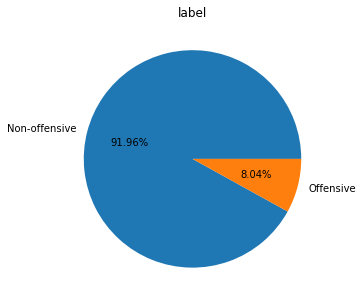

In [110]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
text_df['label'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('label')
plt.ylabel('')
plt.show()

In [94]:
text_df.to_csv('data.csv', encoding='utf_8_sig')

## 該如何處理資料不平衡？